In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# Choose a backend to simulate 
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [3]:
#The interfaces to the classical chemistry codes that are available in Qiskit are called drivers
from qiskit_nature.drivers import PySCFDriver

# importing commands to create a electronic_structure_problem which provides the fermionic operators
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer


# start with the molecule LiH with a bond length of 1.5474
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

# below is the command to print the one-body-integral(h1) and tow-body-integrals; uncomment these 4 lines if you want to see the integrals
#print(" one-body-integral")
#print(qmolecule.one_body_integrals)
#print(" two-body-integral")
#print( qmolecule.two_body_integrals)


# the core electrons does not participate in the motion, so you can remove them with the help of freecoretransformer
freezeCoreTransfomer = FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3,4])

# the reduced molecule in terms of fermionic operator
qmolecule = freezeCoreTransfomer.transform(qmolecule)

# now you can define the electronic structure problem with the reduced molecule
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian in terms of quantized fermionic operators
main_op = second_q_ops[0]


In [11]:
#------Mapping to qubit---------------------
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit.aqua.operators import Z2Symmetries

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

# coverter to map to qubits with the search for z2symmetry
converter = QubitConverter(mapper=mapper,two_qubit_reduction=True,z2symmetry_reduction=[1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

# qubit operator
qubit_op = converter.convert(main_op, num_particles=num_particles)


In [5]:
#-----------Initial_state_with_HF-------------
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)
#-----------------------------------------------



     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


In [6]:
#-------------- Ansatz---------------------------
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from math import pi

# Choose the ansatz
ansatz_type = "Custom"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cy'
    # How the qubits are entangled 
    entanglement = 'circular'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameters
    a,b,c,d,e,f = Parameter('a'),Parameter('b'),Parameter('c'),Parameter('d'),Parameter('e'),Parameter('f')
    g,h,i,j,k,l = Parameter('g'),Parameter('h'),Parameter('i'),Parameter('j'),Parameter('k'),Parameter('l')
    m,N,o,p,q,r = Parameter('m'),Parameter('N'),Parameter('o'),Parameter('p'),Parameter('q'),Parameter('r')

    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0 
    qc.barrier()

    #-----rotation gates------
    qc.ry(a,qubit_label)
    qc.rz(b,qubit_label)
    
    qc.ry(c,1)
    qc.rz(d,1)
    
    qc.ry(e,2)
    qc.rz(f,2)
    
    qc.ry(g,3)
    qc.rz(h,3)
    #-------------------------
    qc.barrier()
    
    #-----entangelars---------
    qc.cy(3,qubit_label)
    qc.cy(qubit_label,1)
    qc.cy(1,2)
    qc.x(3)
    #-------------------------
    qc.barrier()
    
    #-----rotation gates------
    qc.ry(i,qubit_label)
    qc.rz(j,qubit_label)
    
    qc.ry(k,1)
    qc.rz(l,1)
    
    qc.ry(m,2)
    qc.rz(n,2)
    
    qc.ry(o,3)
    qc.rz(p,3)
    #-------------------------
    
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
print(ansatz)

#---------------------------------------------------


     ┌───┐ ░ ┌───────┐┌───────┐ ░ ┌───┐           ░ ┌───────┐┌───────┐
q_0: ┤ X ├─░─┤ RY(a) ├┤ RZ(b) ├─░─┤ Y ├──■────────░─┤ RY(i) ├┤ RZ(j) ├
     ├───┤ ░ ├───────┤├───────┤ ░ └─┬─┘┌─┴─┐      ░ ├───────┤├───────┤
q_1: ┤ X ├─░─┤ RY(c) ├┤ RZ(d) ├─░───┼──┤ Y ├──■───░─┤ RY(k) ├┤ RZ(l) ├
     └───┘ ░ ├───────┤├───────┤ ░   │  └───┘┌─┴─┐ ░ ├───────┤├───────┤
q_2: ──────░─┤ RY(e) ├┤ RZ(f) ├─░───┼───────┤ Y ├─░─┤ RY(m) ├┤ RZ(4) ├
           ░ ├───────┤├───────┤ ░   │  ┌───┐└───┘ ░ ├───────┤├───────┤
q_3: ──────░─┤ RY(g) ├┤ RZ(h) ├─░───■──┤ X ├──────░─┤ RY(o) ├┤ RZ(p) ├
           ░ └───────┘└───────┘ ░      └───┘      ░ └───────┘└───────┘


In [7]:
# use the appropriate optimizer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

#optimizer_type = 'SPSA'
optimizer_type = 'L_BFGS_B'
# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [8]:
#--------------exact_energy_LIH-----------------------
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)
#---------------------------------------------------------

Exact electronic energy -1.08870601573474
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [9]:
#-------------VQE----------------------------------------
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
#try:
   # initial_point = [0.01] * len(ansatz.ordered_parameters)
#except:
initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)
#------------------------------------------

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 512,
    'eigenstate': array([ 3.16500472e-04-1.22370395e-03j, -2.88011232e-03-4.28284469e-03j,
        6.46701856e-03+2.17219024e-02j, -6.32901455e-01-7.63316226e-01j,
       -4.12361780e-02-3.34258047e-02j, -1.29250579e-03+1.26533817e-06j,
        5.63872678e-04+6.30991285e-04j, -2.16909117e-02-1.35984122e-02j,
       -1.21925772e-03+2.64867206e-03j, -9.22955190e-06+6.86239373e-05j,
       -6.79479981e-06+5.36754630e-08j, -1.38230916e-03+5.25732768e-04j,
        7.05283134e-02+8.81744889e-02j,  2.27440608e-03+1.22026842e-03j,
       -4.08773173e-04-4.17106872e-04j, -4.19803637e-05+1.89778621e-05j]),
    'eigenvalue': -1.086267652922415,
    'optimal_parameters': {   Parameter(l): -0.09990143405701309,
                              Parameter(m): 1.644507124055697,
                              Parameter(o): 0.012699908939294128,
                              Parameter(p): -0.0018521355058905415,
                         

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,L_BFGS_B,QuantumCircuit,4,15,None,None,None,None,2.438363,True,3


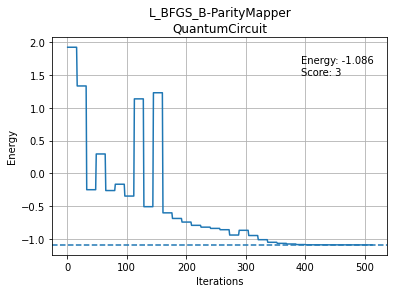

In [13]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
accuracy_thresholdaccuract_thres = 4.0
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_thresholdaccuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

In [10]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

